In [ ]:
###### DON'T USE IT, CRASHES AFTER RUNNING FOR MORE THAN AN HOUR

# from datasets import load_dataset

# # Login using e.g. `huggingface-cli login` to access this dataset
# ds = load_dataset("AisotTechnologies/aisot_btc_lob_trades")

In [ ]:
###### USE THIS METHOD INSTEAD

# from huggingface_hub import snapshot_download

# snapshot_download(repo_id="AisotTechnologies/aisot_btc_lob_trades", allow_patterns="*.zip", local_dir='data/', repo_type='dataset')

Fetching 232 files: 100%|██████████| 232/232 [00:46<00:00,  4.97it/s]


'C:\\Users\\aliak\\my_space\\ETH\\ML Complex Systems\\MLFCS\\data'

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import *

In [3]:
import os
from datasets import load_dataset

# Define the folder containing the ZIP files
data_folder = "./data/"

# Get all ZIP files containing "trx" in the filename
trx_zip_files = [
    os.path.join(data_folder, f) for f in os.listdir(data_folder) 
    if "trx" in f and f.endswith(".zip")
]

# Ensure that matching files were found
if not trx_zip_files:
    raise FileNotFoundError("No matching 'trx' ZIP files found in './data/'.")

# Load dataset using Hugging Face `load_dataset`
trx_dataset = load_dataset("csv", data_files=trx_zip_files)  # Adjust to "parquet" if needed



Resolving data files:   0%|          | 0/122 [00:00<?, ?it/s]

In [4]:
trx_dataset = trx_dataset['train'].to_pandas()
trx_dataset.rename({col:col.split("'")[1].strip() for col in trx_dataset.columns}, axis=1, inplace=True)
trx_dataset['datetime'] = pd.to_datetime(trx_dataset['datetime'])
trx_dataset.head()

,timestamp,price,datetime,cost,id,fee,fee1,order,symbol,amount,type,side
0,1527800413000,7538.34,2018-05-31 21:00:13+00:00,75.383400,67405327,{'currency': u'USD','cost': None},None,BTC/USD,0.010000,None,sell
1,1527800418000,7533.92,2018-05-31 21:00:18+00:00,35.761333,67405331,{'currency': u'USD','cost': None},None,BTC/USD,0.004747,None,sell
2,1527800418000,7535.44,2018-05-31 21:00:18+00:00,2995.337400,67405330,{'currency': u'USD','cost': None},None,BTC/USD,0.397500,None,sell
3,1527800418000,7536.00,2018-05-31 21:00:18+00:00,7.536000,67405329,{'currency': u'USD','cost': None},None,BTC/USD,0.001000,None,sell
4,1527800418000,7537.49,2018-05-31 21:00:18+00:00,753.749000,67405328,{'currency': u'USD','cost': None},None,BTC/USD,0.100000,None,sell


In [5]:
trx_dataset.dtypes

timestamp                  int64
price                    float64
datetime     datetime64[ns, UTC]
cost                     float64
id                         int64
fee                       object
fee1                      object
order                     object
symbol                    object
amount                   float64
type                      object
side                      object
dtype: object

### Preprocessing and Feature Creation

In [6]:
freq = '1min'
# Group by minute and transaction side
trx_dataset_grouped = trx_dataset.groupby([pd.Grouper(key='datetime', freq=freq, label='right', closed='left'), 'side']).agg(
    volume=('amount', 'sum'),  # Sum of volumes
    txn=('side', 'count')         # Count of transactions
).reset_index()

# Pivot to have separate columns for each transaction type
trx_dataset_grouped = trx_dataset_grouped.pivot(index='datetime', columns='side')

# Flatten multi-index columns
trx_dataset_grouped.columns = [f"{col}_{txn_side}" for txn_side, col in trx_dataset_grouped.columns]

# Reset index to make time a column again
trx_dataset_grouped = trx_dataset_grouped.reset_index()
# Fill missing values with 0
trx_dataset_grouped = trx_dataset_grouped.fillna(0)

## The below variable should be True,  set it False to check how plots, statistics change if we don't do it
fill_missing_ts = True

if fill_missing_ts:
    # Create a complete range of minutes
    full_range = pd.DataFrame({'datetime': pd.date_range(start=trx_dataset['datetime'].min().ceil('min'), 
                                                    end=trx_dataset['datetime'].max().ceil('min'), 
                                                    freq='min')})

    # Merge with full time range to ensure all minutes are present
    trx_dataset_grouped = full_range.merge(trx_dataset_grouped, on='datetime', how='left')

    # Fill missing values with 0
    trx_dataset_grouped = trx_dataset_grouped.fillna(0)

trx_dataset_grouped.rename({col:col.strip() for col in trx_dataset_grouped.columns}, axis=1, inplace=True)
trx_dataset_grouped['volume_imbalance'] = np.abs(trx_dataset_grouped["buy_volume"] - trx_dataset_grouped['sell_volume'])
trx_dataset_grouped['txn_imbalance'] = np.abs(trx_dataset_grouped['buy_txn'] - trx_dataset_grouped['sell_txn'])
trx_dataset_grouped['total_volume'] = trx_dataset_grouped["buy_volume"] + trx_dataset_grouped['sell_volume']

trx_dataset_grouped.head()


,datetime,buy_volume,sell_volume,buy_txn,sell_txn,volume_imbalance,txn_imbalance,total_volume
0,2018-05-31 21:01:00+00:00,18.203291,0.677437,12.0,11.0,17.525854,1.0,18.880728
1,2018-05-31 21:02:00+00:00,0.218896,0.946981,5.0,6.0,0.728085,1.0,1.165876
2,2018-05-31 21:03:00+00:00,0.021258,0.011077,3.0,1.0,0.010181,2.0,0.032336
3,2018-05-31 21:04:00+00:00,0.143166,0.001062,8.0,1.0,0.142104,7.0,0.144229
4,2018-05-31 21:05:00+00:00,2.837166,0.000000,9.0,0.0,2.837166,9.0,2.837166


### Stackplot

In [7]:
trx_dataset_grouped['time'] = trx_dataset_grouped['datetime'].dt.time
trx_dataset_grouped_viz = trx_dataset_grouped.groupby("time")['total_volume'].quantile([0.25, 0.5, 0.75]).unstack()
trx_dataset_grouped_viz.rename({0.25:'Q1', 0.5:'Q2', 0.75:'Q3'}, axis=1, inplace=True)
trx_dataset_grouped_viz['Q1_Q2'] = trx_dataset_grouped_viz['Q2'] - trx_dataset_grouped_viz['Q1']  # Lower IQR (blue)
trx_dataset_grouped_viz['Q2_Q3'] = trx_dataset_grouped_viz['Q3'] - trx_dataset_grouped_viz['Q2']  # Upper IQR (green)
# Convert time index to minutes since midnight (numeric format for x-axis)
trx_dataset_grouped_viz['minutes_since_midnight'] = [t.hour * 60 + t.minute for t in trx_dataset_grouped_viz.index]

trx_dataset_grouped_viz.head()

,Q1,Q2,Q3,Q1_Q2,Q2_Q3,minutes_since_midnight
time,,,,,,
00:00:00,0.149442,1.182660,3.371082,1.033218,2.188422,0
00:01:00,0.375942,1.984938,7.351205,1.608996,5.366267,1
00:02:00,0.447086,2.585878,6.315642,2.138792,3.729764,2
00:03:00,0.304207,1.306180,6.271761,1.001973,4.965580,3
00:04:00,0.502046,2.120197,6.226218,1.618151,4.106022,4


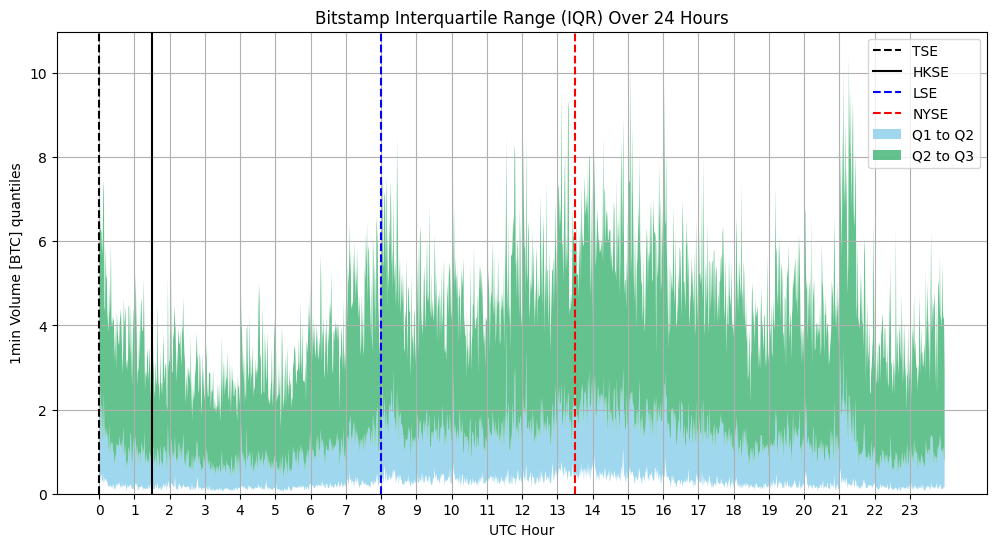

In [8]:
# Calculate IQR ranges


# Plot
fig, ax = plt.subplots(figsize=(12, 6))

minutes = [0, 90, 480, 810]  # Convert times to minutes since midnight

colors = ['black', 'black', 'blue', 'red']
labels = ['TSE', 'HKSE', 'LSE', 'NYSE']
for t, color, label in zip(minutes, colors, labels):
    if label == 'HKSE':
        ax.axvline(x=t, color=color, label=label)
    else:   
        ax.axvline(x=t, linestyle='--', color=color, label=label)

ax.stackplot(trx_dataset_grouped_viz['minutes_since_midnight'], trx_dataset_grouped_viz['Q1'], trx_dataset_grouped_viz['Q1_Q2'], trx_dataset_grouped_viz['Q2_Q3'], 
             labels=["", "Q1 to Q2", "Q2 to Q3"], colors=['none','skyblue', 'mediumseagreen'], edgecolor='none', alpha=0.8)

# Formatting X-axis to show only hours
ax.set_xticks(np.arange(0, 1381, 60))  # Tick every 60 minutes (every hour)
ax.set_xticklabels(range(0, 24))  # Labels from 0 to 23 (only hours)

# Labels and title
ax.set_xlabel("UTC Hour")
ax.set_ylabel("1min Volume [BTC] quantiles")
ax.set_title("Bitstamp Interquartile Range (IQR) Over 24 Hours")
ax.legend()
ax.grid(True)

plt.show()

### Distribution plot

In [9]:
trx_dataset_grouped['time'] = trx_dataset_grouped['datetime'].dt.time

trx_dataset_grouped['mean_volume'] = trx_dataset_grouped.groupby('time')['total_volume'].transform('mean')

trx_dataset_grouped['deseasoned_total_volume'] = trx_dataset_grouped['total_volume'] / trx_dataset_grouped['mean_volume']

In [10]:
print(f"minimal volume after 0 is {trx_dataset_grouped.loc[trx_dataset_grouped['deseasoned_total_volume'] >0]['deseasoned_total_volume'].min()} BTC")
print("!!!!! It is an open question how much to adjust the zero values to be inserted in the logarithm function. For now I choose 1e-7")

minimal volume after 0 is 1.4287888119880103e-07 BTC
!!!!! It is an open question how much to adjust the zero values to be inserted in the logarithm function. For now I choose 1e-7


In [11]:
trx_dataset_grouped['log_deseasoned_total_volume'] = np.log(trx_dataset_grouped['deseasoned_total_volume'] + 1e-7)

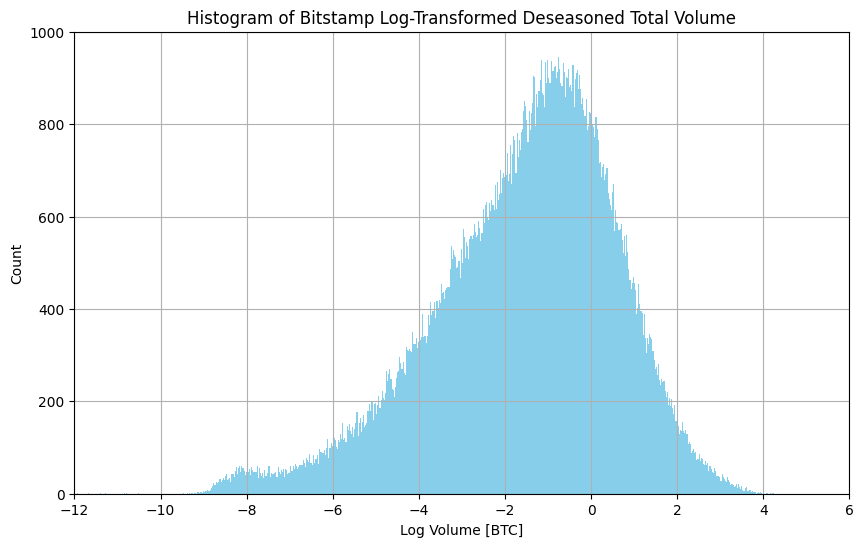

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(trx_dataset_grouped['log_deseasoned_total_volume'], bins=800, color='skyblue', edgecolor='none')
plt.xlim(-12,6)
plt.ylim(0,1000)
plt.title("Histogram of Bitstamp Log-Transformed Deseasoned Total Volume")
plt.xlabel("Log Volume [BTC]")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [13]:
# Calculate mean, variance, skewness, and kurtosis of the 'volume' column
mean_volume = trx_dataset_grouped['log_deseasoned_total_volume'].mean()
variance_volume = trx_dataset_grouped['log_deseasoned_total_volume'].var()
skewness_volume = stats.skew(trx_dataset_grouped['log_deseasoned_total_volume'])
kurtosis_volume = stats.kurtosis(trx_dataset_grouped['log_deseasoned_total_volume'])

# Display the results
print(f"Mean: {mean_volume}")
print(f"Variance: {variance_volume}")
print(f"Skewness: {skewness_volume}")
print(f"Kurtosis: {kurtosis_volume}")

Mean: -2.1415403578139527
Variance: 12.46845304159347
Skewness: -2.426768194801154
Kurtosis: 7.180021839765143


### ACF and PACF

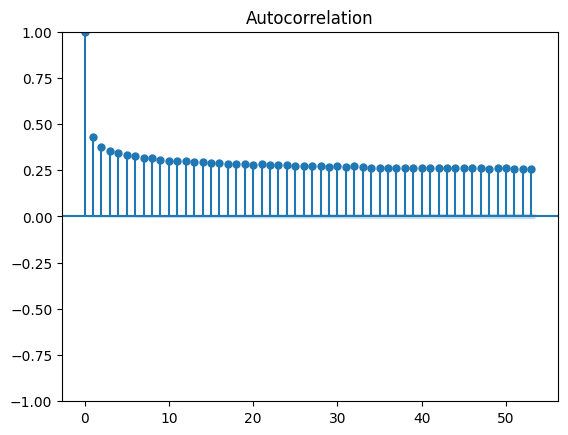

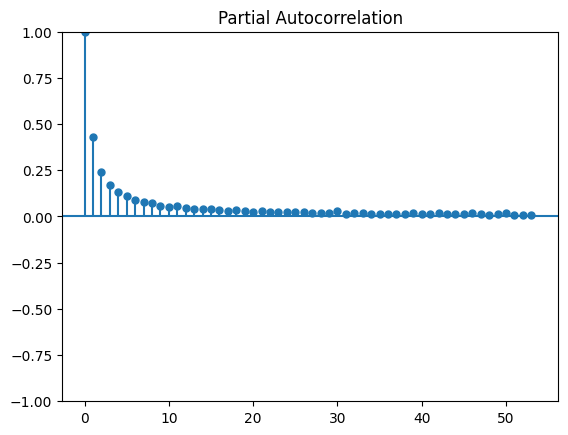

In [14]:
plot_acf(trx_dataset_grouped['log_deseasoned_total_volume']);
plot_pacf(trx_dataset_grouped['log_deseasoned_total_volume']);

### LOB data

In [15]:
trx_zip_files[0]

'./data/bitstamp_trx_01_06_2018.zip'

In [ ]:
# Define the folder containing the ZIP files
data_folder = "./data/"

# Get all ZIP files containing "trx" in the filename
lob_zip_files = [
    os.path.join(data_folder, f) for f in os.listdir(data_folder) 
    if "ob" in f and f.endswith(".zip")
]

# Ensure that matching files were found
if not lob_zip_files:
    raise FileNotFoundError("No matching 'ob' ZIP files found in './data/'.")

len(lob_zip_files)

109

In [16]:
single_file_ob_dataset = ["./data/bitstamp_ob_04_07_2018.zip"]
lob_dataset = load_dataset("csv", data_files=single_file_ob_dataset)

Generating train split: 0 examples [00:00, ? examples/s]

In [17]:
lob_dataset

DatasetDict({
    train: Dataset({
        features: ['time', 'type', 'price', 'amount '],
        num_rows: 24084011
    })
})

In [ ]:
lob_dataset = lob_dataset['train'].to_pandas()
lob_dataset['datetime'] = pd.to_datetime(lob_dataset['time'], unit='s', utc=True)
lob_dataset.drop(['time'], axis=1, inplace = True)
lob_dataset.rename({col:col.strip() for col in lob_dataset.columns}, axis=1, inplace=True)
lob_dataset.head()


,type,price,amount,datetime
0,b,6613.32,0.068823,2018-07-03 22:00:01+00:00
1,b,6613.31,3.709311,2018-07-03 22:00:01+00:00
2,b,6608.79,0.015000,2018-07-03 22:00:01+00:00
3,b,6608.78,1.000000,2018-07-03 22:00:01+00:00
4,b,6608.77,1.911835,2018-07-03 22:00:01+00:00


In [26]:
lob_dataset['datetime'].unique()[:3]

<DatetimeArray>
['2018-07-03 22:00:01+00:00', '2018-07-03 22:00:34+00:00',
 '2018-07-03 22:01:01+00:00']
Length: 3, dtype: datetime64[ns, UTC]

In [23]:
lob_dataset.head(100)

,type,price,amount,datetime
0,b,6613.32,0.068823,2018-07-03 22:00:01+00:00
1,b,6613.31,3.709311,2018-07-03 22:00:01+00:00
2,b,6608.79,0.015000,2018-07-03 22:00:01+00:00
3,b,6608.78,1.000000,2018-07-03 22:00:01+00:00
4,b,6608.77,1.911835,2018-07-03 22:00:01+00:00
...,...,...,...,...
95,b,6536.73,7.000000,2018-07-03 22:00:01+00:00
96,b,6533.09,0.049000,2018-07-03 22:00:01+00:00
97,b,6533.00,0.037653,2018-07-03 22:00:01+00:00
98,b,6530.15,0.502194,2018-07-03 22:00:01+00:00


In [24]:
lob_dataset.tail(100)

,type,price,amount,datetime
24083911,a,13948.97,0.350000,2018-07-04 21:59:34+00:00
24083912,a,13949.97,0.047449,2018-07-04 21:59:34+00:00
24083913,a,13951.00,0.800000,2018-07-04 21:59:34+00:00
24083914,a,13956.79,0.030000,2018-07-04 21:59:34+00:00
24083915,a,13958.00,0.100000,2018-07-04 21:59:34+00:00
...,...,...,...,...
24084006,a,14239.27,0.000557,2018-07-04 21:59:34+00:00
24084007,a,14240.00,0.250562,2018-07-04 21:59:34+00:00
24084008,a,14245.71,0.001229,2018-07-04 21:59:34+00:00
24084009,a,14247.00,0.020000,2018-07-04 21:59:34+00:00


In [20]:
lob_dataset.type.unique()

array(['b', 'a'], dtype=object)

###### Small game-dataset to test feature creation code

In [50]:
# Define data
lb_df = {
    'type': ['b', 'b', 'b', 'b', 'b', 'a', 'a', 'a', 'a', 'a']*2,
    'price': [100, 101, 102, 103, 104, 105, 107, 108, 109, 110]*2,
    'amount': [10, 5, 8, 10, 17, 15, 12, 8, 12, 33]*2,
    'datetime': pd.to_datetime(['2024-03-04 22:31:01'] * 10 + ['2024-03-04 22:32:01'] * 10)  # Convert to datetime
}

# Create DataFrame
lb_df = pd.DataFrame(lb_df)
lb_df

,type,price,amount,datetime
0,b,100,10,2024-03-04 22:31:01
1,b,101,5,2024-03-04 22:31:01
2,b,102,8,2024-03-04 22:31:01
3,b,103,10,2024-03-04 22:31:01
4,b,104,17,2024-03-04 22:31:01
5,a,105,15,2024-03-04 22:31:01
6,a,107,12,2024-03-04 22:31:01
7,a,108,8,2024-03-04 22:31:01
8,a,109,12,2024-03-04 22:31:01
9,a,110,33,2024-03-04 22:31:01


In [59]:
import pandas as pd
import numpy as np

def compute_features(group, thresholds):
    bids = group[group['type'] == 'b'].sort_values(by='price', ascending=False)  # Highest bid first
    asks = group[group['type'] == 'a'].sort_values(by='price', ascending=True)   # Lowest ask first
    
    if bids.empty or asks.empty:
        return pd.Series({
            'Best Ask': np.nan, 'Best Bid': np.nan, 'ask_volume': np.nan, 'bid_volume': np.nan,
            **{f'ask_slope_{x}': np.nan for x in thresholds},
            **{f'bid_slope_{x}': np.nan for x in thresholds}
        })
    
    best_bid = bids['price'].iloc[0]
    best_ask = asks['price'].iloc[0]
    total_bid_volume = bids['amount'].sum()
    total_ask_volume = asks['amount'].sum()
    
    def find_offset_price(df, total_volume, x, side='bid'):
        """Find price level where cumulative volume reaches x% of total volume."""
        cum_vol = df['amount'].cumsum()
        threshold_volume = total_volume * (x / 100)
        idx = (cum_vol >= threshold_volume).idxmax()
        return df.loc[idx, 'price']
    
    ask_slopes = {}
    bid_slopes = {}
    
    for x in thresholds:
        # Compute p_b_x and delta_x_b
        p_b_x = find_offset_price(bids, total_bid_volume, x, 'bid')
        delta_x_b = best_bid - p_b_x
        p_a_delta_x_b = best_ask + delta_x_b
        ask_slopes[f'ask_slope_{x}'] = asks[asks['price'] <= p_a_delta_x_b]['amount'].sum()
        
        # Compute p_a_x and delta_x_a
        p_a_x = find_offset_price(asks, total_ask_volume, x, 'ask')
        delta_x_a = best_ask - p_a_x
        p_b_delta_x_a = best_bid + delta_x_a
        bid_slopes[f'bid_slope_{x}'] = bids[bids['price'] >= p_b_delta_x_a]['amount'].sum()
    
    return pd.Series({
        'Best Ask': best_ask, 'Best Bid': best_bid, 'ask_volume': total_ask_volume, 'bid_volume': total_bid_volume,
        **ask_slopes, **bid_slopes
    })

# Define percentage thresholds
thresholds = [1, 5, 10]
thresholds = [50]

# Group by datetime and compute features
result = lb_df.groupby('datetime').apply(lambda group: compute_features(group, thresholds), include_groups=False).reset_index()
result


,datetime,Best Ask,Best Bid,ask_volume,bid_volume,ask_slope_50,bid_slope_50
0,2024-03-04 22:31:01,105,104,80,50,15,50
1,2024-03-04 22:32:01,105,104,80,50,15,50


In [62]:
thresholds = [1, 5, 10]
lob_dataset_grouped = lob_dataset.groupby('datetime').apply(lambda group: compute_features(group, thresholds), include_groups=False).reset_index()

In [61]:
lob_dataset_grouped.head()

,datetime,Best Ask,Best Bid,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10
0,2018-07-03 22:00:01+00:00,6614.99,6613.32,2501.979545,567123.997426,1323.363422,2404.951714,2408.066048,6.704969,43.533540,154.347958
1,2018-07-03 22:00:34+00:00,6614.99,6613.32,2500.004667,567125.105659,1333.621186,2415.209477,2418.323812,5.884678,33.275745,138.851659
2,2018-07-03 22:01:01+00:00,6614.99,6613.32,2495.362910,567127.754102,1328.948178,2410.536470,2413.650804,6.877432,45.799112,140.500981
3,2018-07-03 22:01:34+00:00,6614.98,6608.82,2495.541990,567127.251110,1328.608508,2410.692728,2413.776134,3.455259,26.664782,141.904405
4,2018-07-03 22:02:01+00:00,6614.25,6608.80,2505.468060,567128.324518,1326.941237,2409.025456,2412.108863,2.965259,36.683320,143.978057


In [63]:
lob_dataset_grouped['spread'] = lob_dataset_grouped['Best Ask'] - lob_dataset_grouped['Best Bid']
lob_dataset_grouped['lob_volume_imbalance'] = np.abs(lob_dataset_grouped['bid_volume'] - lob_dataset_grouped['ask_volume'])
for thresh in thresholds:
    lob_dataset_grouped[f'slope_imbalance_{thresh}'] = np.abs(lob_dataset_grouped[f'ask_slope_{thresh}'] - lob_dataset_grouped[f'bid_slope_{thresh}'])
lob_dataset_grouped.drop(['Best Ask', 'Best Bid'], axis=1, inplace=True)
lob_dataset_grouped.head()

,datetime,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10,spread,lob_volume_imbalance,slope_imbalance_1,slope_imbalance_5,slope_imbalance_10
0,2018-07-03 22:00:01+00:00,2501.979545,567123.997426,1323.363422,2404.951714,2408.066048,6.704969,43.533540,154.347958,1.67,564622.017881,1316.658453,2361.418174,2253.718089
1,2018-07-03 22:00:34+00:00,2500.004667,567125.105659,1333.621186,2415.209477,2418.323812,5.884678,33.275745,138.851659,1.67,564625.100992,1327.736507,2381.933732,2279.472153
2,2018-07-03 22:01:01+00:00,2495.362910,567127.754102,1328.948178,2410.536470,2413.650804,6.877432,45.799112,140.500981,1.67,564632.391192,1322.070746,2364.737358,2273.149822
3,2018-07-03 22:01:34+00:00,2495.541990,567127.251110,1328.608508,2410.692728,2413.776134,3.455259,26.664782,141.904405,6.16,564631.709120,1325.153249,2384.027946,2271.871729
4,2018-07-03 22:02:01+00:00,2505.468060,567128.324518,1326.941237,2409.025456,2412.108863,2.965259,36.683320,143.978057,5.45,564622.856458,1323.975978,2372.342136,2268.130806


In [ ]:
# !!!!!!!!!!!! ATTENTION !!!!!!!!!!!!!!!!!!!!!!!!!!
# It executes for more than 3 hours
# Creating LOB features
df_full_lob = pd.DataFrame()
thresholds = [1, 5, 10]

for file in tqdm(lob_zip_files):
    single_file_ob_dataset = [file]
    lob_dataset = load_dataset("csv", data_files=single_file_ob_dataset)

    lob_dataset = lob_dataset['train'].to_pandas()
    lob_dataset['datetime'] = pd.to_datetime(lob_dataset['time'], unit='s', utc=True)
    lob_dataset.drop(['time'], axis=1, inplace = True)
    lob_dataset.rename({col:col.strip() for col in lob_dataset.columns}, axis=1, inplace=True)

    lob_dataset_grouped = lob_dataset.groupby('datetime').apply(lambda group: compute_features(group, thresholds), include_groups=False).reset_index()
    df_full_lob = pd.concat([df_full_lob, lob_dataset_grouped], ignore_index=True)

  1%|          | 1/109 [00:19<35:33, 19.75s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  2%|▏         | 2/109 [01:06<1:03:29, 35.61s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  3%|▎         | 3/109 [01:56<1:14:53, 42.39s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  4%|▎         | 4/109 [02:45<1:18:10, 44.67s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  5%|▍         | 5/109 [04:14<1:45:31, 60.88s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  6%|▌         | 6/109 [05:47<2:03:00, 71.66s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  6%|▋         | 7/109 [07:22<2:15:01, 79.42s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  7%|▋         | 8/109 [08:53<2:19:48, 83.06s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  8%|▊         | 9/109 [10:21<2:20:48, 84.49s/it]

Generating train split: 0 examples [00:00, ? examples/s]

  9%|▉         | 10/109 [11:48<2:21:06, 85.52s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 10%|█         | 11/109 [13:15<2:20:01, 85.73s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 11%|█         | 12/109 [14:43<2:19:57, 86.57s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 12%|█▏        | 13/109 [16:11<2:19:20, 87.08s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 13%|█▎        | 14/109 [17:42<2:19:46, 88.28s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 14%|█▍        | 15/109 [19:10<2:17:58, 88.07s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 15%|█▍        | 16/109 [20:37<2:16:07, 87.83s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 16%|█▌        | 17/109 [22:05<2:14:37, 87.79s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 17%|█▋        | 18/109 [23:31<2:12:17, 87.23s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 17%|█▋        | 19/109 [24:57<2:10:18, 86.87s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 18%|█▊        | 20/109 [26:48<2:19:25, 94.00s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 19%|█▉        | 21/109 [29:32<2:48:58, 115.21s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 20%|██        | 22/109 [31:44<2:54:19, 120.22s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 21%|██        | 23/109 [33:56<2:57:13, 123.64s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 22%|██▏       | 24/109 [36:08<2:58:45, 126.19s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 23%|██▎       | 25/109 [38:22<2:59:47, 128.42s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 24%|██▍       | 26/109 [40:42<3:02:26, 131.89s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 25%|██▍       | 27/109 [42:51<2:59:18, 131.20s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 26%|██▌       | 28/109 [44:57<2:54:57, 129.60s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 27%|██▋       | 29/109 [46:54<2:47:48, 125.86s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 28%|██▊       | 30/109 [48:23<2:31:00, 114.69s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 28%|██▊       | 31/109 [50:27<2:32:37, 117.41s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 29%|██▉       | 32/109 [52:42<2:37:37, 122.83s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 30%|███       | 33/109 [54:56<2:39:42, 126.09s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 31%|███       | 34/109 [57:10<2:40:49, 128.66s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 32%|███▏      | 35/109 [59:44<2:47:51, 136.10s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 33%|███▎      | 36/109 [1:01:54<2:43:34, 134.45s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 34%|███▍      | 37/109 [1:04:11<2:42:04, 135.06s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 35%|███▍      | 38/109 [1:06:26<2:39:54, 135.13s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 36%|███▌      | 39/109 [1:08:40<2:37:13, 134.77s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 37%|███▋      | 40/109 [1:10:52<2:33:57, 133.88s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 38%|███▊      | 41/109 [1:13:06<2:31:46, 133.93s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 39%|███▊      | 42/109 [1:15:17<2:28:36, 133.08s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 39%|███▉      | 43/109 [1:17:36<2:28:24, 134.91s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 40%|████      | 44/109 [1:19:48<2:25:03, 133.91s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 41%|████▏     | 45/109 [1:21:26<2:11:33, 123.33s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 42%|████▏     | 46/109 [1:23:38<2:12:14, 125.94s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 43%|████▎     | 47/109 [1:25:58<2:14:22, 130.03s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 44%|████▍     | 48/109 [1:28:14<2:13:59, 131.80s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 45%|████▍     | 49/109 [1:29:44<1:59:15, 119.26s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 46%|████▌     | 50/109 [1:31:57<2:01:18, 123.36s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 47%|████▋     | 51/109 [1:34:17<2:03:57, 128.23s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 48%|████▊     | 52/109 [1:36:29<2:02:55, 129.39s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 49%|████▊     | 53/109 [1:38:22<1:56:20, 124.66s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 50%|████▉     | 54/109 [1:39:54<1:45:05, 114.65s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 50%|█████     | 55/109 [1:41:24<1:36:41, 107.44s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 51%|█████▏    | 56/109 [1:42:50<1:29:14, 101.03s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 52%|█████▏    | 57/109 [1:44:30<1:27:09, 100.57s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 53%|█████▎    | 58/109 [1:45:57<1:22:10, 96.68s/it] 

Generating train split: 0 examples [00:00, ? examples/s]

 54%|█████▍    | 59/109 [1:47:25<1:18:24, 94.10s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 55%|█████▌    | 60/109 [1:48:54<1:15:31, 92.47s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 56%|█████▌    | 61/109 [1:50:30<1:14:53, 93.60s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 57%|█████▋    | 62/109 [1:52:01<1:12:38, 92.74s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 58%|█████▊    | 63/109 [1:53:31<1:10:31, 91.98s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 59%|█████▊    | 64/109 [1:55:01<1:08:34, 91.43s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 60%|█████▉    | 65/109 [1:56:37<1:08:01, 92.75s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 61%|██████    | 66/109 [1:58:08<1:05:58, 92.05s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 61%|██████▏   | 67/109 [1:59:34<1:03:19, 90.47s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 62%|██████▏   | 68/109 [2:01:07<1:02:09, 90.96s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 63%|██████▎   | 69/109 [2:02:42<1:01:32, 92.31s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 64%|██████▍   | 70/109 [2:03:37<52:47, 81.22s/it]  

Generating train split: 0 examples [00:00, ? examples/s]

 65%|██████▌   | 71/109 [2:05:07<53:03, 83.79s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 66%|██████▌   | 72/109 [2:06:33<52:02, 84.40s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 67%|██████▋   | 73/109 [2:08:07<52:26, 87.41s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 68%|██████▊   | 74/109 [2:09:37<51:27, 88.22s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 69%|██████▉   | 75/109 [2:11:07<50:15, 88.68s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 70%|██████▉   | 76/109 [2:12:29<47:40, 86.68s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 71%|███████   | 77/109 [2:14:04<47:32, 89.14s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 72%|███████▏  | 78/109 [2:15:33<45:59, 89.02s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 72%|███████▏  | 79/109 [2:17:04<44:49, 89.67s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 73%|███████▎  | 80/109 [2:18:29<42:42, 88.37s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 74%|███████▍  | 81/109 [2:20:08<42:44, 91.58s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 75%|███████▌  | 82/109 [2:21:41<41:19, 91.83s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 76%|███████▌  | 83/109 [2:23:10<39:27, 91.06s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 77%|███████▋  | 84/109 [2:24:36<37:20, 89.63s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 78%|███████▊  | 85/109 [2:25:46<33:24, 83.53s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 79%|███████▉  | 86/109 [2:26:33<27:49, 72.61s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 80%|███████▉  | 87/109 [2:27:22<24:04, 65.67s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 81%|████████  | 88/109 [2:28:10<21:03, 60.17s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 82%|████████▏ | 89/109 [2:29:03<19:21, 58.07s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 83%|████████▎ | 90/109 [2:29:53<17:39, 55.74s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 83%|████████▎ | 91/109 [2:30:42<16:07, 53.78s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 84%|████████▍ | 92/109 [2:31:29<14:35, 51.52s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 85%|████████▌ | 93/109 [2:32:21<13:48, 51.77s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 86%|████████▌ | 94/109 [2:33:08<12:35, 50.36s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 87%|████████▋ | 95/109 [2:33:58<11:41, 50.14s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 88%|████████▊ | 96/109 [2:34:43<10:34, 48.82s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 89%|████████▉ | 97/109 [2:35:37<10:04, 50.39s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 90%|████████▉ | 98/109 [2:36:26<09:09, 49.91s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 91%|█████████ | 99/109 [2:37:14<08:13, 49.32s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 92%|█████████▏| 100/109 [2:38:18<08:03, 53.69s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 93%|█████████▎| 101/109 [2:39:58<09:00, 67.51s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 94%|█████████▎| 102/109 [2:41:35<08:54, 76.42s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 94%|█████████▍| 103/109 [2:43:05<08:03, 80.52s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 95%|█████████▌| 104/109 [2:44:32<06:51, 82.38s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 96%|█████████▋| 105/109 [2:46:15<05:55, 88.77s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 97%|█████████▋| 106/109 [2:47:51<04:32, 90.68s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 98%|█████████▊| 107/109 [2:49:22<03:01, 90.98s/it]

Generating train split: 0 examples [00:00, ? examples/s]

 99%|█████████▉| 108/109 [2:51:03<01:33, 93.83s/it]

Generating train split: 0 examples [00:00, ? examples/s]

100%|██████████| 109/109 [2:52:41<00:00, 95.06s/it]


In [68]:
df_full_lob.head()

,datetime,Best Ask,Best Bid,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10
0,2018-07-03 22:00:01+00:00,6614.99,6613.32,2501.979545,567123.997426,1323.363422,2404.951714,2408.066048,6.704969,43.533540,154.347958
1,2018-07-03 22:00:34+00:00,6614.99,6613.32,2500.004667,567125.105659,1333.621186,2415.209477,2418.323812,5.884678,33.275745,138.851659
2,2018-07-03 22:01:01+00:00,6614.99,6613.32,2495.362910,567127.754102,1328.948178,2410.536470,2413.650804,6.877432,45.799112,140.500981
3,2018-07-03 22:01:34+00:00,6614.98,6608.82,2495.541990,567127.251110,1328.608508,2410.692728,2413.776134,3.455259,26.664782,141.904405
4,2018-07-03 22:02:01+00:00,6614.25,6608.80,2505.468060,567128.324518,1326.941237,2409.025456,2412.108863,2.965259,36.683320,143.978057


In [69]:
df_full_lob.tail()

,datetime,Best Ask,Best Bid,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10
311901,2018-08-31 21:57:34+00:00,7024.19,7020.25,2418.351756,512592.225235,1299.697775,2232.333189,2257.175802,13.661290,212.297666,266.766177
311902,2018-08-31 21:58:01+00:00,7024.19,7020.25,2423.074590,512593.152718,1304.470608,2237.106023,2261.948636,13.662602,213.225149,267.693660
311903,2018-08-31 21:58:33+00:00,7027.99,7020.26,2417.513964,512593.178267,1293.496393,2226.146643,2251.007210,7.788149,213.250698,255.466973
311904,2018-08-31 21:59:01+00:00,7026.89,7020.28,2416.129545,512591.616601,1294.236802,2226.886224,2251.726791,4.636949,211.689032,253.905307
311905,2018-08-31 21:59:33+00:00,7027.65,7021.64,2420.986317,512591.871165,1302.160329,2235.140318,2259.650318,2.136942,208.042465,254.159871


In [74]:
df_full_lob.head()

,datetime,Best Ask,Best Bid,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10
8640,2018-06-04 22:00:02+00:00,7543.19,7537.00,2695.804973,586356.113693,1761.630667,2695.804973,2695.804973,3.972121,53.502450,160.246934
8641,2018-06-04 22:00:34+00:00,7543.19,7537.00,2696.561478,586351.269401,1762.459233,2696.561478,2696.561478,3.339124,52.739443,155.402642
8642,2018-06-04 22:01:01+00:00,7541.97,7537.00,2699.165417,586350.938081,1765.312385,2699.165417,2699.165417,4.017044,52.408273,155.071322
8643,2018-06-04 22:01:33+00:00,7541.97,7537.01,2656.934508,586307.355517,1724.074201,2656.934508,2656.934508,4.090007,47.761226,159.376480
8644,2018-06-04 22:02:02+00:00,7541.90,7537.00,2657.946212,586317.596946,1723.843180,2657.946212,2657.946212,3.831055,46.578294,158.194750


In [77]:
df_full_lob.sort_values('datetime', inplace=True)
df_full_lob.reset_index(inplace=True)

In [ ]:
df_full_lob['spread'] = df_full_lob['Best Ask'] - df_full_lob['Best Bid']
df_full_lob['lob_volume_imbalance'] = np.abs(df_full_lob['bid_volume'] - df_full_lob['ask_volume'])
thresholds = [1, 5, 10]
for thresh in thresholds:
    df_full_lob[f'slope_imbalance_{thresh}'] = np.abs(df_full_lob[f'ask_slope_{thresh}'] - df_full_lob[f'bid_slope_{thresh}'])
# df_full_lob.drop(['Best Ask', 'Best Bid'], axis=1, inplace=True)
df_full_lob.head()

,datetime,Best Ask,Best Bid,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10,spread,lob_volume_imbalance,slope_imbalance_1,slope_imbalance_5,slope_imbalance_10
8640,2018-06-04 22:00:02+00:00,7543.19,7537.00,2695.804973,586356.113693,1761.630667,2695.804973,2695.804973,3.972121,53.502450,160.246934,6.19,583660.308720,1757.658546,2642.302523,2535.558040
8641,2018-06-04 22:00:34+00:00,7543.19,7537.00,2696.561478,586351.269401,1762.459233,2696.561478,2696.561478,3.339124,52.739443,155.402642,6.19,583654.707923,1759.120109,2643.822035,2541.158836
8642,2018-06-04 22:01:01+00:00,7541.97,7537.00,2699.165417,586350.938081,1765.312385,2699.165417,2699.165417,4.017044,52.408273,155.071322,4.97,583651.772664,1761.295341,2646.757144,2544.094095
8643,2018-06-04 22:01:33+00:00,7541.97,7537.01,2656.934508,586307.355517,1724.074201,2656.934508,2656.934508,4.090007,47.761226,159.376480,4.96,583650.421009,1719.984195,2609.173283,2497.558029
8644,2018-06-04 22:02:02+00:00,7541.90,7537.00,2657.946212,586317.596946,1723.843180,2657.946212,2657.946212,3.831055,46.578294,158.194750,4.90,583659.650734,1720.012125,2611.367918,2499.751462


In [ ]:
df_full_lob.to_csv("data/df_full_lob.csv")